# Model Training notebook

Contains the whole pipeline to train the models.  
How to use:   

Run the first cells to import all needed models and functions  
Then run the cell that loads the weights, if none are present it will create a new model  
Run the training cell and adjust N and iterations accordingly. Using a higher N will use more RAM, so you can lower N and augment iterations.  
Finally if the results are are good, you can save the model weigths. Only do it if the results are nice, because it overwrites the old weigths. 
The last cell vizualizes 3 different reference images with very different D values. 

In [36]:
# Hyperparameters for simulation
nparticles = 1000   # Number of particles
nframes = 8    # Number of steps in the simulation
nposframe = 10    # Number of position per frame
dt = 0.01        # Integration time frame in second (time between two frames)
DGen = 10000        # Diffusion coefficient in nm^2 per s (=0.001 (um^2)/s)
num_steps = nframes*nposframe
# Hyperparameters for image generation
npixel = 64 # number of image pixels
pixelsize = 100 # in nm 
fwhm_psf = 200 # full width half maximum (emulates microscope)
factor_hr = 5 # image high resulution factor
flux = 100 # number of photons per s
poisson_noise = 100 
gaussian_noise = 10
background = 100 # base background value
normalizeValue = 1000 # value by which all samples will be normalized ! Needs to be fixed and the same for all images !
n_val_im = 50


In [37]:
%reload_ext autoreload
%autoreload 2
from helpers import *
from modelsUtils import *
from simpleCNNModel import *
from ResNetModel import *
from paperCNN import *
import os.path

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [68]:
# Models used in a dictionnary comprehension. 
# To add  anew model, simply add it to the liost with the wanted train fct

lr = 0.00001
models_params = {
    "simpleCNN": {"class": DiffusionPredictorCNN, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "resNet": {"class": ResNetDiffusionPredictor, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "paperCNNAdam": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "paperCNNSGD": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "sgd", "lr" :lr}
}

In [69]:
for name, params in models_params.items():
    class_ = params["class"]
    # Load the model weights
    loaded_model = class_().to(device)
    filename = "w_" + name + ".pth"
    if os.path.exists(filename):
        loaded_model = load_model_weights(loaded_model, filename)
        print(name, "Loaded existing weights")
    else:
        print(name, "Did not find weights, loaded a new model")
        
    params["loaded_model"] = loaded_model  # Update the dictionary with the loaded model
    
    if(isinstance(params["optimizer"],str)):
        if params["optimizer"] == "adam":
            params["optimizer"] = optim.Adam(loaded_model.parameters(), lr=params["lr"])
        elif params["optimizer"] == "sgd":
            params["optimizer"] = optim.SGD(loaded_model.parameters(), lr=params["lr"], momentum=0.9)
        else: 
            params["optimizer"] = optim.Adam(loaded_model.parameters(), lr=params["lr"])



Model weights loaded from w_simpleCNN.pth
simpleCNN Loaded existing weights
Model weights loaded from w_resNet.pth
resNet Loaded existing weights
Model weights loaded from w_paperCNNAdam.pth
paperCNNAdam Loaded existing weights
Model weights loaded from w_paperCNNSGD.pth
paperCNNSGD Loaded existing weights


In [60]:
# run this cell to reset loss histories
tr_loss_histories = {name: [] for name in models_params.keys()}
val_loss_histories = {name: [] for name in models_params.keys()}

allGeneratedDs = np.array([])
totalEpochs = 0

In [61]:
# load validation images
val_trajs = np.load('validation_trajectories.npy')
val_images, valDs = generateImagesAndEstimateDFromTrajs(val_trajs,n_val_im, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
valDs = torch.tensor(valDs/1000, dtype=torch.float32, device=device)


In [70]:
epochs = 50
N = 128  # Number of samples per iteration

totalEpochs = totalEpochs + epochs
for i in range(epochs):

    print(f"Generating images for iteration: {i}")

    images, estimatedDs =  generateImagesAndEstimateD(N, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
    
    # Divide the estimateDs by 10000 to get values in the range 0.5->50, then add them to the list of all Ds
    estimatedDs = estimatedDs / 1000
    allGeneratedDs = np.append(allGeneratedDs,estimatedDs)
    

    # Add channel dimension to images: (N, 8, 64, 64) -> (N, 8, 1, 64, 64)
    images = torch.tensor(images, dtype=torch.float32).unsqueeze(2)
    estimatedDs = torch.tensor(estimatedDs, dtype=torch.float32)


    for name, params in models_params.items():
        model = params["loaded_model"]
        train_fct = params["train_fct"]
        criterion = params["criterion"]
        optimizer = params["optimizer"]

        print("Training model:" , name)
        trained_model, tr_loss_history = train_fct(model, images, estimatedDs, device, criterion, optimizer, epochs=1, batch_size=16)
        params["loaded_model"] = trained_model

        # Compute validation loss on fixed set of images
        model_preds = predict_diffusion_coefficients(trained_model, val_images ,device)
        loss = criterion(model_preds, valDs)
        val_loss_histories[name].append(loss.item())



        # Store the single training epoch loss
        if isinstance(tr_loss_history, list) and len(tr_loss_history) > 0:
            tr_loss_histories[name].append(tr_loss_history[-1])  # Append last loss in the history
        elif isinstance(tr_loss_history, (float, int)):  # If it's a single loss value
            tr_loss_histories[name].append(tr_loss_history)
        else:
            print(f"Unexpected loss format for model {name}: {tr_loss_history}")


Generating images for iteration: 0
Training model: simpleCNN
Epoch 1/1, Loss: 60.2655
Training model: resNet
Epoch 1/1, Loss: 8.3759
Training model: paperCNNAdam
Epoch 1/1, Loss: 2.7430
Training model: paperCNNSGD
Epoch 1/1, Loss: 60.2758
Generating images for iteration: 1
Training model: simpleCNN
Epoch 1/1, Loss: 57.9981
Training model: resNet
Epoch 1/1, Loss: 5.8596
Training model: paperCNNAdam
Epoch 1/1, Loss: 2.8041
Training model: paperCNNSGD
Epoch 1/1, Loss: 58.0244
Generating images for iteration: 2
Training model: simpleCNN
Epoch 1/1, Loss: 80.9212
Training model: resNet
Epoch 1/1, Loss: 9.0178
Training model: paperCNNAdam
Epoch 1/1, Loss: 3.0467
Training model: paperCNNSGD
Epoch 1/1, Loss: 80.8411
Generating images for iteration: 3
Training model: simpleCNN
Epoch 1/1, Loss: 57.8221
Training model: resNet
Epoch 1/1, Loss: 6.1846
Training model: paperCNNAdam
Epoch 1/1, Loss: 2.2627
Training model: paperCNNSGD
Epoch 1/1, Loss: 57.9078
Generating images for iteration: 4
Training 

0.7150066133716707


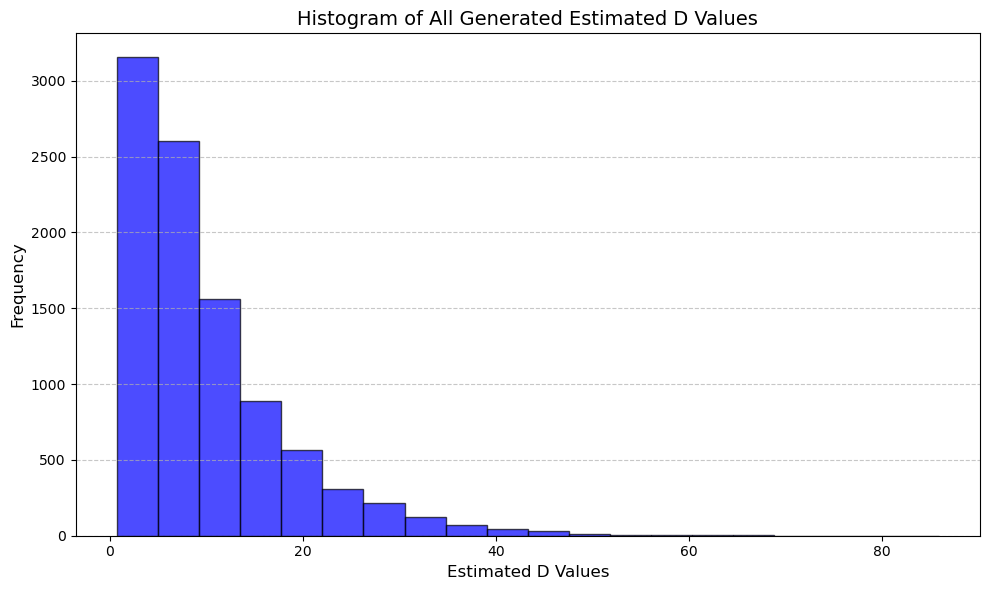

In [71]:

print(np.min(allGeneratedDs))
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(allGeneratedDs, bins=20, color='blue', edgecolor='black', alpha=0.7)

# Add labels, title, and grid
plt.xlabel('Estimated D Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of All Generated Estimated D Values', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()


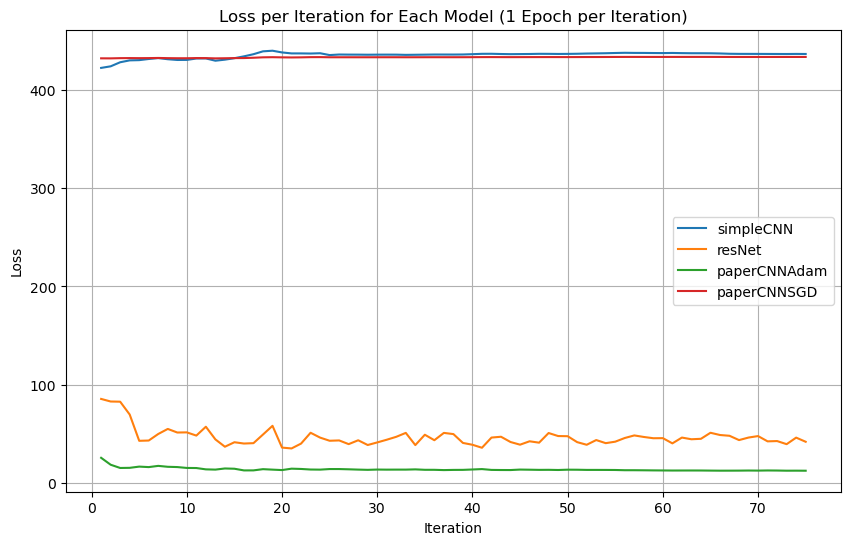

C:\Users\Emilien\AppData\Local\Temp\ipykernel_13800\2365436183.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valDs_tensor = torch.tensor(valDs, dtype=model_preds.dtype, device=model_preds.device)


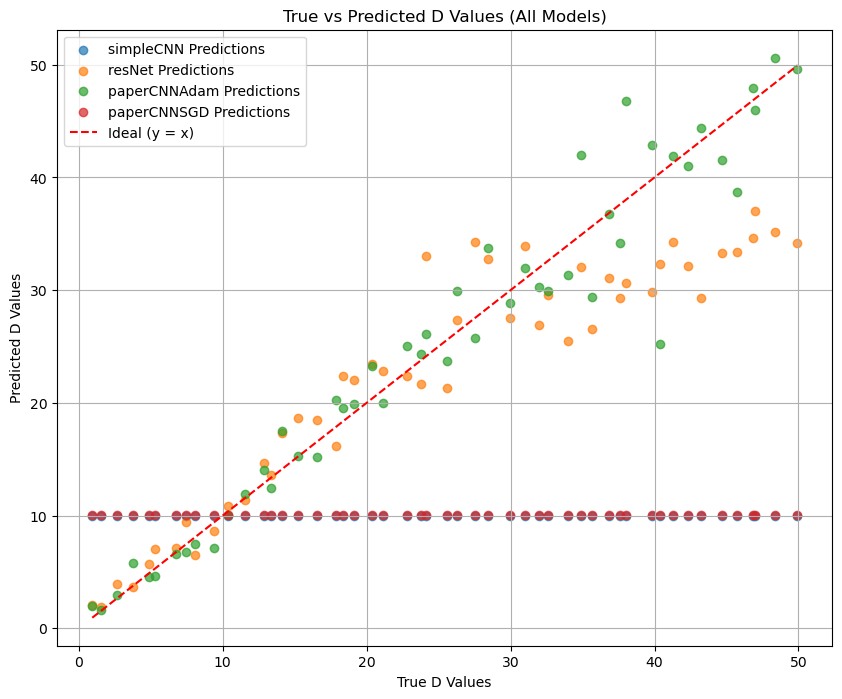

In [74]:
plt.figure(figsize=(10, 6))
for model_name, losses in val_loss_histories.items():
    plt.plot(range(1, totalEpochs + 1), losses, label=model_name)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss per Iteration for Each Model (1 Epoch per Iteration)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))

# Iterate over all models to plot predictions vs true values
for name, params in models_params.items():
    # Predictions and true values
    model = params["loaded_model"]
    model_preds = predict_diffusion_coefficients(model, val_images, device)
    valDs_tensor = torch.tensor(valDs, dtype=model_preds.dtype, device=model_preds.device)
    
    # Ensure predictions and true values are on the same device and flattened
    model_preds = model_preds.view(-1).cpu().numpy()  # Convert to numpy for plotting
    valDs_array = valDs_tensor.view(-1).cpu().numpy()  # Convert to numpy for plotting

    # Scatter plot for the current model
    plt.scatter(valDs_array, model_preds, alpha=0.7, label=f'{name} Predictions')

# Plot the ideal line
min_val, max_val = min(valDs_array), max(valDs_array)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y = x)')

# Add plot details
plt.title("True vs Predicted D Values (All Models)")
plt.xlabel("True D Values")
plt.ylabel("Predicted D Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

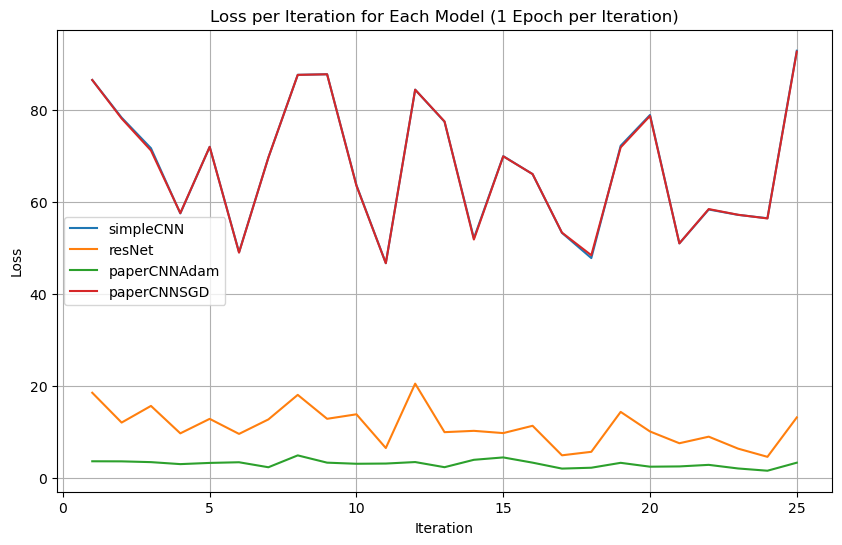

In [66]:

plt.figure(figsize=(10, 6))
for model_name, losses in tr_loss_histories.items():
    plt.plot(range(1, totalEpochs + 1), losses, label=model_name)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss per Iteration for Each Model (1 Epoch per Iteration)')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
# saves all used models 

for name, params in models_params.items():
    model = params["loaded_model"]
    filename = "w_"+name+".pth"
    save_model_weights(model,filename)

Model weights saved to w_simpleCNN.pth
Model weights saved to w_resNet.pth
Model weights saved to w_paperCNNAdam.pth
Model weights saved to w_paperCNNSGD.pth


Image loaded from refImageSmall.npy
Real D value for image refImageSmall of model: simpleCNN : 1.9350. Model estimated value: 9.9311
Real D value for image refImageSmall of model: resNet : 1.9350. Model estimated value: 3.5535
Real D value for image refImageSmall of model: paperCNNAdam : 1.9350. Model estimated value: 1.8010
Real D value for image refImageSmall of model: paperCNNSGD : 1.9350. Model estimated value: 10.0318


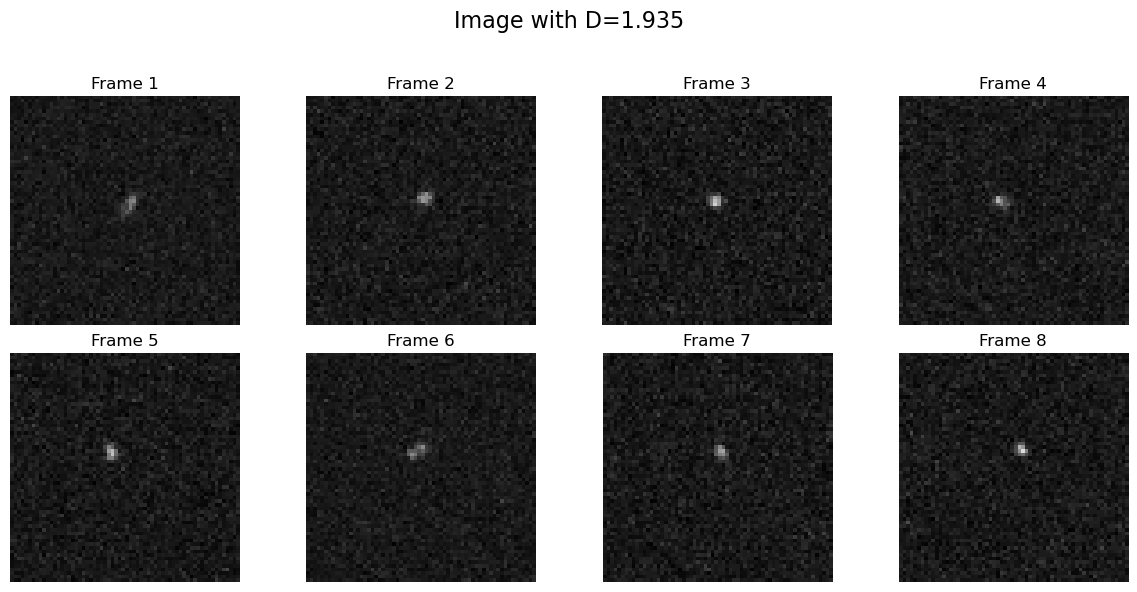

Image loaded from refImage.npy
Real D value for image refImage of model: simpleCNN : 13.8750. Model estimated value: 9.9311
Real D value for image refImage of model: resNet : 13.8750. Model estimated value: 9.6482
Real D value for image refImage of model: paperCNNAdam : 13.8750. Model estimated value: 14.2315
Real D value for image refImage of model: paperCNNSGD : 13.8750. Model estimated value: 10.0318


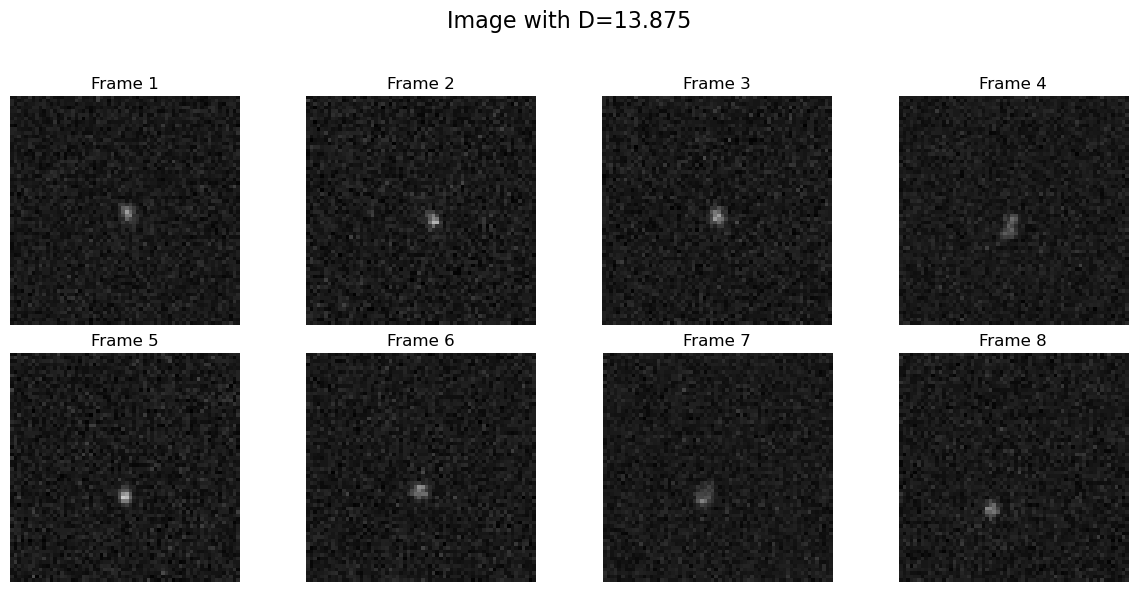

Image loaded from refImageBig.npy
Real D value for image refImageBig of model: simpleCNN : 26.0920. Model estimated value: 9.9311
Real D value for image refImageBig of model: resNet : 26.0920. Model estimated value: 35.0272
Real D value for image refImageBig of model: paperCNNAdam : 26.0920. Model estimated value: 22.5965
Real D value for image refImageBig of model: paperCNNSGD : 26.0920. Model estimated value: 10.0318


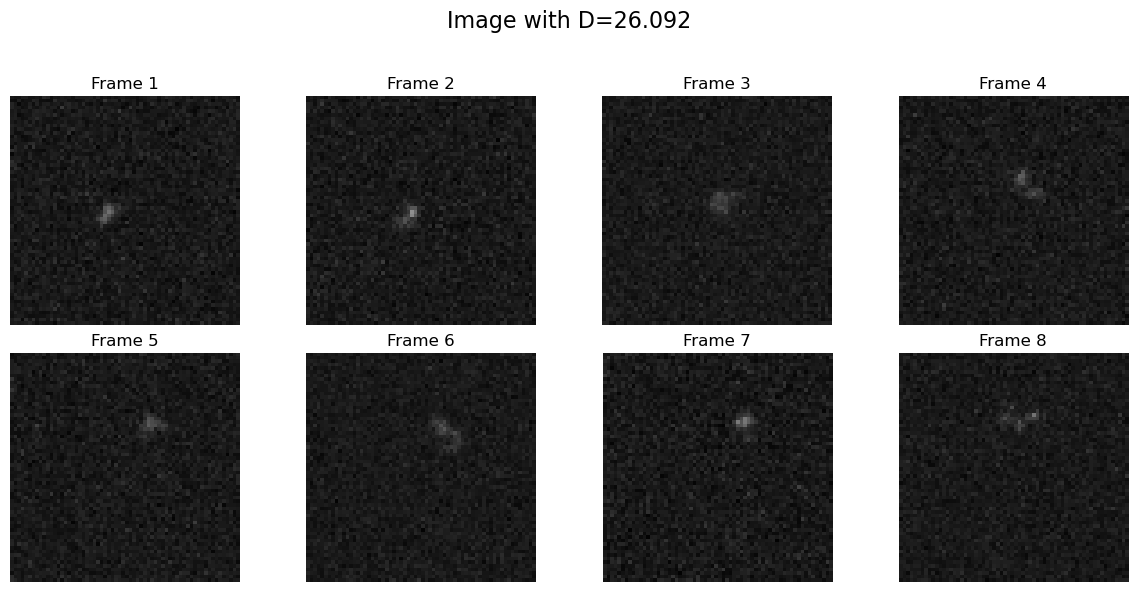

In [77]:
# Uncomment these 3 lines to generate a new reference image
#singleIm, singleestimatedDs = generateImagesAndEstimateD(1, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
#im, estD = singleIm[0,:], singleestimatedDs[0]
#save_image(im,"refImageBig.npy") 


# We created 3 reference images, with different D values, to observe what our algorithm predicts
dict = {"refImageSmall": 1.935, "refImage": 13.875, "refImageBig": 26.092}

for iname, estD in dict.items():
    im = load_image(iname + ".npy")
    for mname, params in models_params.items():
        model = params["loaded_model"]

        modelEstimation = predict_diffusion_coefficients(model, im ,device)
        print(f"Real D value for image {iname} of model: {mname} : {estD:.4f}. Model estimated value: {modelEstimation:.4f}")

    plot_image_frames(im,f"Image with D={estD}")


In [ ]:
# run this code to generate new 50 reference images that will be used to compute the validation loss at each iteration
"""
parts = 10000
trajectories = brownian_motion(parts,nframes,nposframe,DGen,dt,False)
time_range = np.arange(nframes * nposframe) * dt / nposframe

nIm = 50

trajsToSave = np.zeros((nIm,nframes*nposframe,2))
saved = np.zeros(nIm)
print(saved)

for p in range(parts):
    traj = trajectories[p,:]
    msd = mean_square_displacement(traj)
    estimD = estimateDfromMSD(msd,time_range)


    index = int(estimD/1000)
    if(index < nIm and saved[index] == 0 ):
        saved[index] = 1
        trajsToSave[index,:] = traj

print(saved)
np.save('validation_trajectories.npy',trajsToSave)"""